In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
pd.set_option("display.max_columns",999)

In [3]:
pd.set_option("display.max_row",999)

In [ ]:
# Reading the data files

In [50]:
train = pd.read_csv('train_data_w_weather.csv')
train.head(2)

Species  Trap  Latitude  Longitude  WnvPresent  AvgSpeed  \
0  CULEX PIPIENS/RESTUANS  T002  41.95469 -87.800991           0       6.5   
1          CULEX RESTUANS  T002  41.95469 -87.800991           0       6.5   

   Cool  Day_of_year  Depart  Heat  PrecipTotal  ResultDir  ResultSpeed  \
0   9.0          149    10.0   0.0          0.0         18          5.8   
1   9.0          149    10.0   0.0          0.0         18          5.8   

   SeaLevel  StnPressure  Tavg  Tmax  Tmin  
0     30.11        29.39  74.0    88    60  
1     30.11        29.39  74.0    88    60

In [6]:
test = pd.read_csv('../test.csv')

Things to keep in mind

- model applied to test data MUST look at species (by the design of the test data)
- - culex pipens/restuans are records with the two species (not separated)
- predictions must be per check (for a given species). So it doesn't matter how many times the virus is present in the 'batch' as long as it is.--> numbers
Account for structural change by location (hygiene, & whatnot)


Looking at the test data also revealed __there is a mistake__ in the test template csv that also constitutes a leakage of information (for the training).

Records where numbers of mosquitos higher than 50 lead to their splitting in more records where left as they were, (with just the number of mosquitos column and the WnvPresent columns absent)

My personal challenge is to get a high score (also by the leaderboard) (the competition is over, no unfair advantage) so will use that leakage. But I will do a "more proper" model to report true(r) auc score & show difference in portfolio

_(Special case: T009 & T035 have at least two entries for every date for even super rare species)_

In [74]:
set(train.Trap).symmetric_difference(set(test.Trap))

{'T002A',
 'T002B',
 'T065A',
 'T090A',
 'T090B',
 'T090C',
 'T128A',
 'T200A',
 'T200B',
 'T218A',
 'T218B',
 'T218C',
 'T234'}

In [7]:
weather_data = pd.read_csv('../weather.csv')

In [53]:
weather_data.head()

Station        Date  Tmax  Tmin Tavg Depart  DewPoint WetBulb Heat Cool  \
0        1  2007-05-01    83    50   67     14        51      56    0    2   
1        2  2007-05-01    84    52   68      M        51      57    0    3   
2        1  2007-05-02    59    42   51     -3        42      47   14    0   
3        2  2007-05-02    60    43   52      M        42      47   13    0   
4        1  2007-05-03    66    46   56      2        40      48    9    0   

  Sunrise Sunset CodeSum Depth Water1 SnowFall PrecipTotal StnPressure  \
0    0448   1849             0      M      0.0        0.00       29.10   
1       -      -             M      M        M        0.00       29.18   
2    0447   1850      BR     0      M      0.0        0.00       29.38   
3       -      -   BR HZ     M      M        M        0.00       29.44   
4    0446   1851             0      M      0.0        0.00       29.39   

  SeaLevel  ResultSpeed  ResultDir AvgSpeed  
0    29.82          1.7         27      9.2  
1    29.82          2.7         25      9.6  
2    30.09         13.0          4     13.4  
3    30.08         13.3          2     13.4  
4    30.12         11.7          7     11.9

Minor Data munging

In [8]:
train["Date"]=pd.to_datetime(train.Date)
test["Date"]=pd.to_datetime(test.Date)

---

### Using location versus using traps

traps seem to have different status according to time, so...

In [16]:
#showing look of years with records of rows per trap

trap_groups = train[["Trap", "Date", "Latitude", "Longitude"]].groupby(by="Trap")
for trap in list(set(train.Trap)):
    print trap_groups.get_group(trap).Date.apply(lambda x: x.year).unique()

[2007 2009 2011 2013]
[2007 2009]
[2007]
[2007 2009 2011 2013]
[2007]
[2007]
[2007]
[2007 2009 2011 2013]
[2007 2009 2011 2013]
[2007 2009 2011 2013]
[2007 2009 2011 2013]
[2007 2009 2011 2013]
[2007 2009 2011 2013]
[2007 2009]
[2007]
[2007]
[2007 2009 2011 2013]
[2007 2009 2011 2013]
[2007 2009 2011]
[2007 2009 2011 2013]
[2007 2009 2011 2013]
[2007]
[2007]
[2007]
[2007]
[2007 2009 2011 2013]
[2007 2009 2011 2013]
[2007]
[2007 2009 2011]
[2007 2009 2011 2013]
[2007 2009 2011]
[2007 2009 2011 2013]
[2007]
[2007]
[2007]
[2007]
[2009 2011 2013]
[2007]
[2007]
[2007 2009 2011 2013]
[2007]
[2007]
[2007 2009 2011 2013]
[2007 2009 2011 2013]
[2007 2011 2013]
[2009 2011 2013]
[2007 2009 2011 2013]
[2007 2009 2011 2013]
[2007 2009 2011 2013]
[2007 2009 2011 2013]
[2007 2011 2013]
[2007]
[2009 2011 2013]
[2009]
[2009 2011 2013]
[2009 2011 2013]
[2009 2011 2013]
[2009 2011 2013]
[2009 2011 2013]
[2007 2009 2011 2013]
[2007 2009 2011 2013]
[2007 2009 2011 2013]
[2009 2011 2013]
[2007]
[2007 2009]


as a further look to what it does to our training data

In [ ]:
"""#showing look of count of rows per trap

trap_groups = train[["Trap", "Latitude", "Longitude"]].groupby(by="Trap")

fig =  plt.figure(figsize=(10,8))
ax = fig.add_subplot(121)
ax.hist([x.shape[0] for x in [trap_groups.get_group(trap) for trap in list(set(train.Trap))]], bins =80)
ax.set(xlabel = "Number of records" ,ylabel = "Count of traps" ) 

ax2 = fig.add_subplot(122)
ax2.hist([x.shape[0] for x in [trap_groups.get_group(trap) for trap in list(set(train.Trap))]], bins =80)
ax2.set(xlabel = "Number of records" ,ylabel = "Count of traps", xlim=(0,200))


plt.show()"""

__Basic solution : assigning traps with inconsistent records to closest others__

In [20]:
#Basic code to assign traps with inconsistent records to others

traps_4Y = []
for trap in list(set(train.Trap)):
    if len(trap_groups.get_group(trap).Date.apply(lambda x: x.year).unique()) >= 4:
        traps_4Y.append(trap)

print len(traps_4Y)
print len(train.Trap.unique())   

53
136


In [21]:
for_knn_traps = train.loc[train.Trap.apply(lambda x: x in traps_4Y), ["Trap", "Latitude", "Longitude"]]
for_knn_traps = for_knn_traps.pivot_table(index="Trap",values=["Latitude","Longitude"])

In [26]:
from sklearn.neighbors import KNeighborsClassifier

In [27]:
#new dataframe
train_w_4Y_traps = train.copy()

knn_traps_4Y = KNeighborsClassifier(n_neighbors = 1)
model = knn_traps_4Y.fit(for_knn_traps,for_knn_traps.index) 

trap_groups = train.groupby(by="Trap")
for trap in list(set(train.Trap).symmetric_difference(set(traps_4Y))):
    pred = model.predict(trap_groups.get_group(trap)[['Latitude','Longitude']])
    train_w_4Y_traps.loc[(train_w_4Y_traps["Trap"]==trap),"Trap"]=pred[0]

In [29]:
#showing NEW look of years with records of rows per trap

trap_groups = train_w_4Y_traps[["Trap", "Date", "Latitude", "Longitude"]].groupby(by="Trap")
for trap in list(set(train_w_4Y_traps.Trap)):
    print trap_groups.get_group(trap).Date.apply(lambda x: x.year).unique()

[2007 2009 2011 2013]
[2007 2009 2011 2013]
[2007 2009 2011 2013]
[2007 2009 2011 2013]
[2007 2009 2011 2013]
[2007 2009 2011 2013]
[2007 2009 2011 2013]
[2007 2009 2011 2013]
[2007 2009 2011 2013]
[2007 2009 2011 2013]
[2007 2009 2011 2013]
[2007 2009 2011 2013]
[2007 2009 2011 2013]
[2007 2009 2011 2013]
[2007 2009 2011 2013]
[2007 2009 2011 2013]
[2007 2009 2011 2013]
[2007 2009 2011 2013]
[2007 2009 2011 2013]
[2007 2009 2011 2013]
[2007 2009 2011 2013]
[2007 2009 2011 2013]
[2007 2009 2011 2013]
[2007 2009 2011 2013]
[2007 2009 2011 2013]
[2007 2009 2011 2013]
[2007 2009 2011 2013]
[2007 2009 2011 2013]
[2007 2009 2011 2013]
[2007 2009 2011 2013]
[2007 2009 2011 2013]
[2007 2009 2011 2013]
[2007 2009 2011 2013]
[2007 2009 2011 2013]
[2007 2009 2011 2013]
[2007 2009 2011 2013]
[2007 2009 2011 2013]
[2007 2009 2011 2013]
[2007 2009 2011 2013]
[2007 2009 2011 2013]
[2007 2009 2011 2013]
[2007 2009 2011 2013]
[2007 2009 2011 2013]
[2007 2009 2011 2013]
[2007 2009 2011 2013]
[2007 2009

In [31]:
"""train_w_4Y_traps.to_csv("train_4Ytraps.csv", index_label= False)"""

# EDA

---

### Records with the virus vs. without

In [51]:
train.WnvPresent.value_counts(normalize=True)

0    0.947554
1    0.052446
Name: WnvPresent, dtype: float64

Time of the year

In [93]:
from scipy import stats

In [ ]:
# computing statistics to be plotted
no_math_mean = np.mean(no_wnv["Day_of_year"])
w_math_mean = np.mean(with_wnv["Day_of_year"])

no_math_median = np.median(no_wnv["Day_of_year"])
w_math_median = np.median(with_wnv["Day_of_year"])

no_math_mode = stats.mode([int(i) for i in no_wnv["Day_of_year"]])
no_math_mode_plt = int(list(no_math_mode)[0])
w_math_mode = stats.mode([int(i) for i in with_wnv["Day_of_year"]])
w_math_mode_plt = int(list(w_math_mode)[0])

no_math_std = np.std(no_wnv["Day_of_year"])
w_math_std = np.std(with_wnv["Day_of_year"])

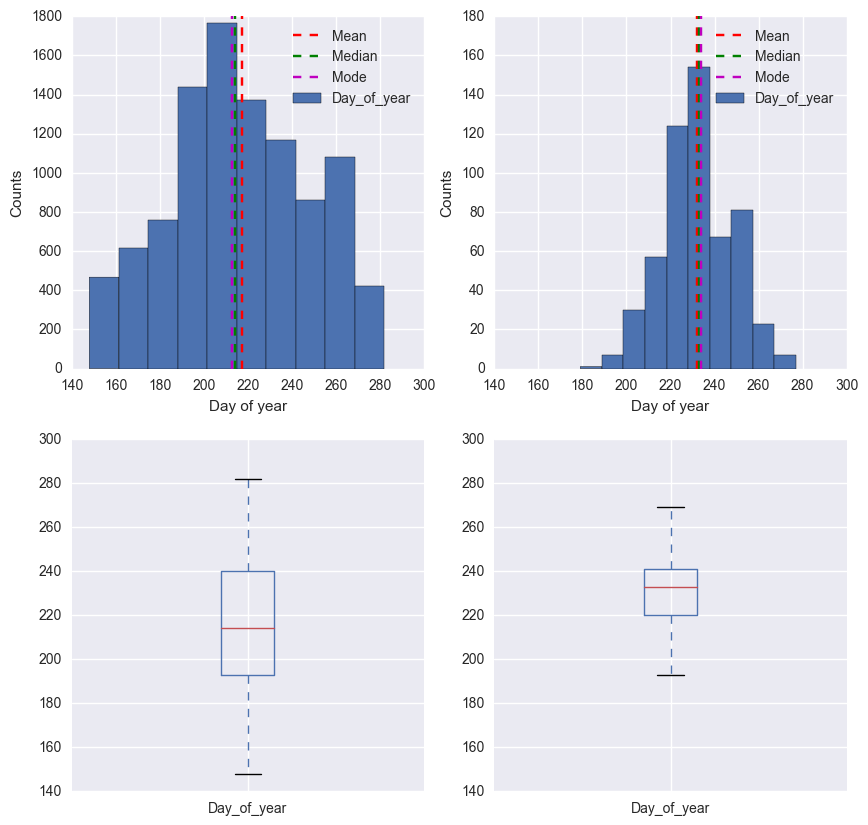

In [97]:
# graph plotting
fig = plt.figure(figsize=(10,10))

ax0 = fig.add_subplot(221)
ax1 = fig.add_subplot(222)
ax2 = fig.add_subplot(223)
ax3 = fig.add_subplot(224)

no_wnv = train.groupby("WnvPresent").get_group(0)
with_wnv = train.groupby("WnvPresent").get_group(1)

# comparable histograms
ax0.hist(no_wnv["Day_of_year"])

ax0.set(xlabel = 'Day of year', ylabel = 'Counts')
ax0.axvline(no_math_mean, color='r', linestyle='dashed', label='Mean')
ax0.axvline(no_math_median, color='g', linestyle='dashed', label='Median')
ax0.axvline(no_math_mode_plt, color='m', linestyle='dashed', label='Mode')
ax0.legend() #This shows the legends in the top right corner

ax1.hist(with_wnv["Day_of_year"])
ax1.set(xlim = (140,300), ylim = (0,180))

ax1.set(xlabel = 'Day of year', ylabel = 'Counts')
ax1.axvline(w_math_mean, color='r', linestyle='dashed', label='Mean')
ax1.axvline(w_math_median, color='g', linestyle='dashed', label='Median')
ax1.axvline(w_math_mode_plt, color='m', linestyle='dashed', label='Mode')
ax1.legend() 

#comparable boxplots
no_wnv['Day_of_year'].plot.box(ax=ax2)
with_wnv['Day_of_year'].plot.box(ax=ax3)
ax3.set(ylim = (140,300))
 
plt.show()

Looking at weather depending on presence of virus

### Mosquito species

Count of presence (at least one) in traps per species

In [59]:
train.Species.value_counts()

CULEX PIPIENS/RESTUANS    4752
CULEX RESTUANS            2740
CULEX PIPIENS             2699
CULEX TERRITANS            222
CULEX SALINARIUS            86
CULEX TARSALIS               6
CULEX ERRATICUS              1
Name: Species, dtype: int64

Count of mosquitos caught by species

In [58]:
for species in train.Species.unique():
    print species+":", sum(train[train.Species==species].NumMosquitos)

CULEX PIPIENS/RESTUANS: 66268
CULEX RESTUANS: 23431
CULEX PIPIENS: 44671
CULEX SALINARIUS: 145
CULEX TERRITANS: 510
CULEX TARSALIS: 7
CULEX ERRATICUS: 7


Records with positive Wnv per mosquito species

In [7]:
pd.pivot_table(train, index=['Species'], values=['WnvPresent'], aggfunc=[np.mean,np.sum])

mean        sum
                       WnvPresent WnvPresent
Species                                     
CULEX ERRATICUS          0.000000          0
CULEX PIPIENS            0.088922        240
CULEX PIPIENS/RESTUANS   0.055135        262
CULEX RESTUANS           0.017883         49
CULEX SALINARIUS         0.000000          0
CULEX TARSALIS           0.000000          0
CULEX TERRITANS          0.000000          0

### NumMosquitos over years at each trap

In [30]:
plt.figure(figsize=(100,100))

for ind, trap in enumerate(list(set(train.Trap))):
    plt.subplot(17,8,ind+1) #17 rows & 8 columns is the
    train[train.Trap==trap].set_index('Date', drop=True).NumMosquitos.resample('2A').sum().plot.bar(label="NumMos_"+trap, rot=15)
    
    #amend "Records" plot so that bars for each year are displaced side to side
    plt.legend(loc='upper left',fontsize=20)

In [13]:
#With same y axis

plt.figure(figsize=(100,100))

ax=plt.subplot(17,8,1) #17 rows & 8 columns is the
train[train.Trap==trap].set_index('Date', drop=True).NumMosquitos.resample('2A').sum().plot.bar(label="NumMos_T152", rot=15)
    
plt.legend(loc='upper left',fontsize=20)
for ind, trap in enumerate(list(set(train.Trap))[1:]):
    plt.subplot(17,8,ind+1,sharey=ax) #17 rows & 8 columns is the
    train[train.Trap==trap].set_index('Date', drop=True).NumMosquitos.resample('2A').sum().plot.bar(label="NumMos_"+trap, rot=15)

    plt.legend(loc='upper left',fontsize=20)

In [38]:
#With same y axis, taking 2 large traps "without interest" away

plt.figure(figsize=(100,100))

ax=plt.subplot(17,8,1) #17 rows & 8 columns is the
train[train.Trap==trap].set_index('Date', drop=True).NumMosquitos.resample('2A').sum().plot.bar(label="NumMos_T152", rot=15)
    
plt.legend(loc='upper left',fontsize=20)
for ind, trap in enumerate(list(set(train.Trap[train.Trap!="T115"][train.Trap!="T138"]))[1:]):
    plt.subplot(17,8,ind+1,sharey=ax) #17 rows & 8 columns is the
    train[train.Trap==trap].set_index('Date', drop=True).NumMosquitos.resample('2A').sum().plot.bar(label="NumMos_"+trap, rot=15)

    plt.legend(loc='upper left',fontsize=20)

Notes to self (Wally):
Some traps have stopped being checked after certain first years --> most definitely a strategic choice...

(check number of mosquitos against number of records (rows) --> DONE:number of records seems to stay stable

### Positive records over years at each trap

In [33]:
plt.figure(figsize=(100,100))
for ind, trap in enumerate(list(set(train.Trap))):
    plt.subplot(17,8,ind+1) #17 rows & 8 columns is the
    train[train.Trap==trap].set_index('Date', drop=True).WnvPresent.resample('2A').sum().plot.bar(label="WnvPosRecords"+trap, rot=15)
    #amend "Records" plot so that bars for each year are displaced side to side
    plt.legend(loc='upper left',fontsize=20)

In [7]:
# With same y axis

plt.figure(figsize=(100,100))

ax=plt.subplot(17,8,1) #17 rows & 8 columns is the
train[train.Trap==trap].set_index('Date', drop=True).WnvPresent.resample('2A').sum().plot.bar(label="WnvPosRecords"+"T152", rot=15)
    
plt.legend(loc='upper left',fontsize=20)
for ind, trap in enumerate(list(set(train.Trap))[1:]):
    plt.subplot(17,8,ind+1,sharey=ax) #17 rows & 8 columns is the
    train[train.Trap==trap].set_index('Date', drop=True).WnvPresent.resample('2A').sum().plot.bar(label="WnvPosRecords"+trap, rot=15)
    #amend "Records" plot so that bars for each year are displaced side to side
    plt.legend(loc='upper left',fontsize=20)

Notes to self (Wally):
- T900 --> 2009 to 2011 to 2013 (increase) (trap was not here in 2007(perhaps it was in 2008))
- T115 --> 2007 to 2009, (dec)

__Case Study: Trap T900__

In [28]:
case_studies=train[train.Trap=="T900"]

In [29]:
case_studies.head()

Date                                            Address  \
3868 2009-05-28  ORD Terminal 5, O'Hare International Airport, ...   
3869 2009-05-28  ORD Terminal 5, O'Hare International Airport, ...   
3963 2009-06-03  ORD Terminal 5, O'Hare International Airport, ...   
3964 2009-06-03  ORD Terminal 5, O'Hare International Airport, ...   
3965 2009-06-03  ORD Terminal 5, O'Hare International Airport, ...   

                     Species  Block            Street  Trap  \
3868          CULEX RESTUANS     10   W OHARE AIRPORT  T900   
3869          CULEX RESTUANS     10   W OHARE AIRPORT  T900   
3963  CULEX PIPIENS/RESTUANS     10   W OHARE AIRPORT  T900   
3964  CULEX PIPIENS/RESTUANS     10   W OHARE AIRPORT  T900   
3965  CULEX PIPIENS/RESTUANS     10   W OHARE AIRPORT  T900   

                  AddressNumberAndStreet   Latitude  Longitude  \
3868  1000  W OHARE AIRPORT, Chicago, IL  41.974689 -87.890615   
3869  1000  W OHARE AIRPORT, Chicago, IL  41.974689 -87.890615   
3963  1000  W OHARE AIRPORT, Chicago, IL  41.974689 -87.890615   
3964  1000  W OHARE AIRPORT, Chicago, IL  41.974689 -87.890615   
3965  1000  W OHARE AIRPORT, Chicago, IL  41.974689 -87.890615   

      AddressAccuracy  NumMosquitos  WnvPresent  
3868                9            30           0  
3869                9             4           0  
3963                9            22           0  
3964                9            50           0  
3965                9            21           0